## Inspecting the WheatFspm model

The goal of this notebook is to inspect the prediction targets and observable state available in the WheatFspm model.

As a dataset, the NEMA model is used from Barillot et al. 2016 (H0, H3, and H15).

### Loading the dataset

These datasets were collected and converted in the WheatFspm repository.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

In [2]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

In [3]:
from src.model.rc_dataset import ExperimentDataset

dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

### Inspecting regime change in plant state (2022-03-25)

I noticed a clear regime change around step 850 for NEMA_H3. I think to err on the safe side I will not include anything past this point in the dataset because it will only worsen the score and we only want to study plants that are in pseudo-static state for now.

`state__An` seems to be a good indicator for detecting the mode switch.

In [4]:
dataset = dataset_nema_h3
dataset_name = 'NEMA_H3'
state_var = 'state__An'
data = dataset.get_state(state_var, dataset_name)

print(data.shape)

(1200, 21)


In [21]:
from sklearn.preprocessing import StandardScaler

(96, 10)


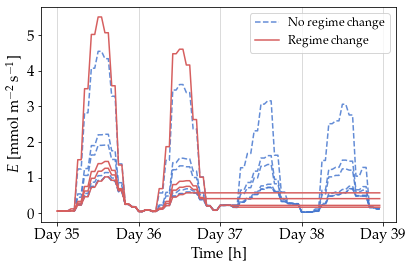

In [84]:
dataset = dataset_nema_h3
dataset_name = 'NEMA_H3'
state_var = 'state__Tr'
data = dataset.get_state(state_var, dataset_name)


# Filter out NaN and zero series
X_NaN = np.isnan(data)
NaN_idx = np.any(X_NaN, axis=0)
X_null = np.isclose(data, 0)
null_idx = np.all(X_null, axis=0)
data = data[:, ~NaN_idx & ~null_idx]

# data = (data - data.mean()) / data.std()


non_functional = [0, 2, 7, 9]
functional = [1, 3, 4, 5, 6, 8]

START = 816
END = 912
time = [np.arange(START, END) for i in range(data.shape[1])]
time = np.stack(time).T
data = data[START:END]

print(data.shape)


with plt.style.context('seaborn-muted'):
  fig, ax = plt.subplots(1, 1, figsize=(6, 4))
  colors = sns.color_palette()

  for i in functional:
    if i is not functional[0]:
      ax.plot(time[:, i], data[:, i], c=colors[0], alpha=0.85, linestyle='--')
    else:
      ax.plot(time[:, i], data[:, i], c=colors[0], alpha=0.85, linestyle='--', label='No regime change')
  
  for i in non_functional:
    if i is not non_functional[0]:
      sns.lineplot(x=time[:, i], y=data[:, i], ax=ax, color=colors[2], alpha=1)
    else:
      sns.lineplot(x=time[:, i], y=data[:, i], ax=ax, color=colors[2], alpha=1, label='Regime change')
  ax.legend()

  # Configure X axis
  TICKRATE = 24
  LABELRATE = 24
  x_ticks = np.arange(START, END + 1, TICKRATE)
  ax.set_xticks(x_ticks)
  x_ticklabels = [f'Day {(i // 24) + 1}' if not i % (LABELRATE) else '' for i in x_ticks]
  ax.set_xticklabels(x_ticklabels)
  ax.set_xlabel(r'Time [\unit{\hour}]')
  ax.grid(axis='x', linestyle='solid', color='lightgrey')
  # ax.set_title(names[col], fontsize=15)
  ax.set_ylabel(r'$E$ [\unit{\milli\mol\per\meter\squared\per\second}]')


  plt.tight_layout()
  plt.savefig('cn_regime_change.png', dpi=200, facecolor='white')

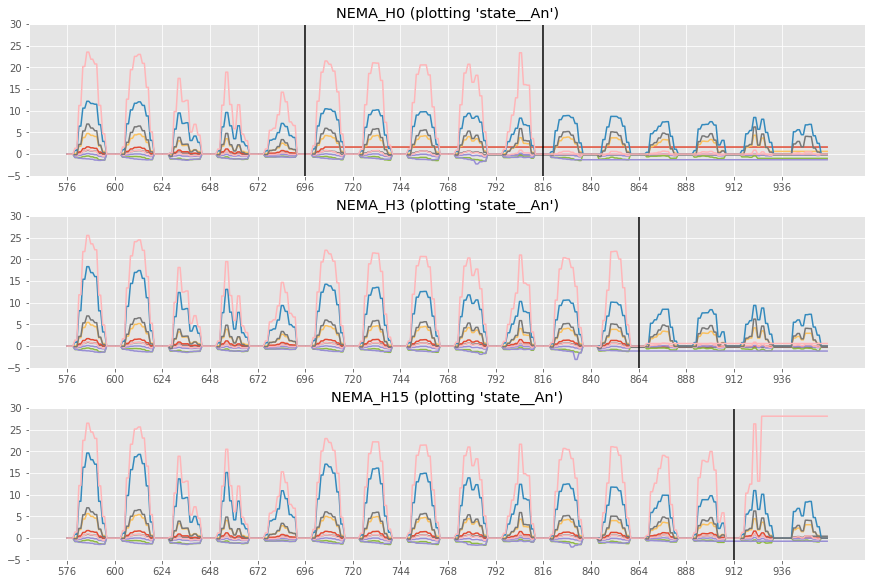

In [77]:
dataset_names = ['NEMA_H0', 'NEMA_H3', 'NEMA_H15']
datasets = (dataset_nema_h0, dataset_nema_h3, dataset_nema_h15)
state_var = 'state__An'
# bounds = (
#   (500, 800), 
#   (864 - 48, 864 + 48),
#   (0, 1000)
# )

bounds = (
  (792 - 9 * 24, 960),
  (792 - 9 * 24, 960),
  (792 - 9 * 24, 960),
)

boundary = ((696, 816), 864, 912)

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(3, 1, figsize=(12, 8), constrained_layout=True)
  
  for i, (_dataset, (min_t, max_t)) in enumerate(zip(datasets, bounds)):
    data = _dataset.get_state(state_var, dataset_names[i])
    data = data[min_t:max_t]

    ax[i].plot(np.arange(min_t, max_t), data)
    ax[i].vlines(boundary[i], -5, 30, color='black')
    ax[i].set_xticks(np.arange(min_t, max_t, 24))
    ax[i].set_ylim(-5, 30)
    ax[i].set_title(f'{dataset_names[i]} (plotting \'{state_var}\')')

  plt.show()  